In [1]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesOccupancyDataset(
    data_dir='/mnt/f/datasets/nuscenes/nuScenes-Occupancy-v0.1/', binary=False)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor

In [ ]:
def occ_shuffle(occ: Tensor, cube_size: int = 32, shuffle_rato: float = 0.2):
    total_cubes = (occ.shape[-3] // cube_size) * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size)
    total_shuffle = int(total_cubes * shuffle_rato)
    cubes = torch.zeros(occ.shape[0], occ.shape[1], total_cubes, cube_size, cube_size, cube_size)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                cubes[:, :, ind] = occ[:, :, i * cube_size:(i + 1) * cube_size, j * cube_size:(j + 1) * cube_size, k * cube_size:(k + 1) * cube_size] 
    ind_to_shuffle = torch.randperm(total_cubes)[:total_shuffle]
    shuffle_ind = torch.randperm(total_shuffle)
    cubes[:, :, ind_to_shuffle] = cubes[:, :, ind_to_shuffle][:, :, shuffle_ind]
    shuffled = torch.zeros_like(occ)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                shuffled[:, :, i*cube_size:(i+1)*cube_size, j*cube_size:(j+1)*cube_size, k*cube_size:(k+1)*cube_size] = cubes[:, :, ind]
    return shuffled
                
    

In [ ]:
occ = nusc[12]
occ = F.interpolate(occ.unsqueeze(0).float(), scale_factor=2, mode='trilinear', align_corners=True).squeeze(0).argmax(0)
occ = F.one_hot(occ, num_classes=18).permute(3, 0, 1, 2).argmax(0)
occ = occ_shuffle(occ[None, None, ...], 64,0.2)[0, 0]
i,j,k = torch.where(occ)
c = occ[i,j,k]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i,j,k, c=c, marker='s', s=1)
ax.set_xlim(0, occ.shape[-3])
ax.set_ylim(0, occ.shape[-2])
ax.set_zlim(0, occ.shape[-1])
ax.set_box_aspect((1,1,occ.shape[-1]/occ.shape[-2]))


In [ ]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained('stabilityai/sdxl-vae')

In [2]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesDataset(
    data_dir='/mnt/f/datasets/nuscenes/')

In [3]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.v2.functional as TF
import torch

data = nusc[0]

In [4]:
occ0 = data.lidar_top.occupancy
occ0.shape

torch.Size([1, 1, 256, 256, 32])

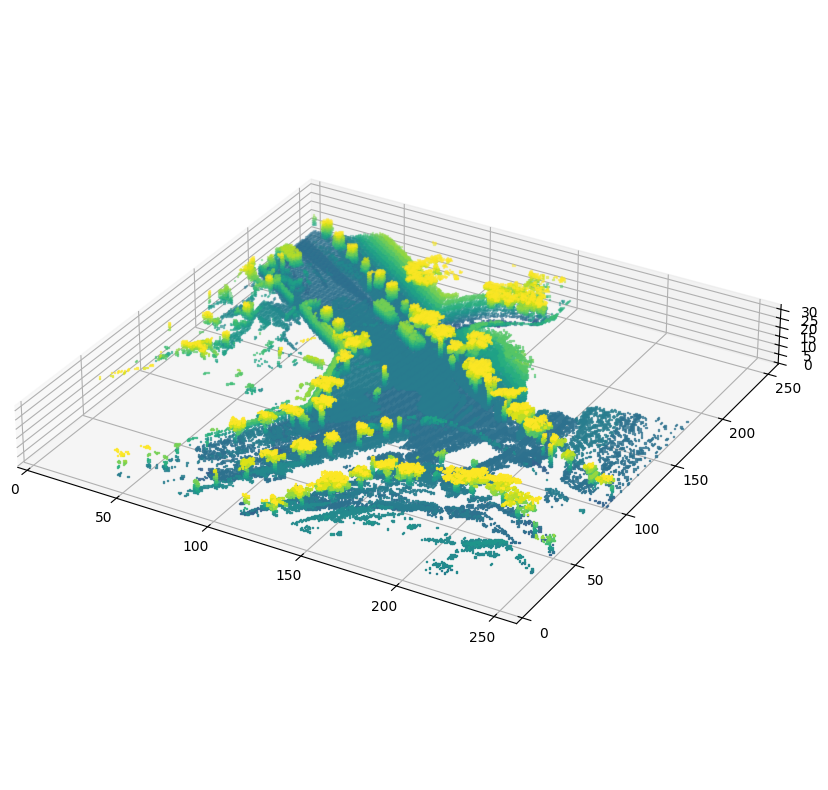

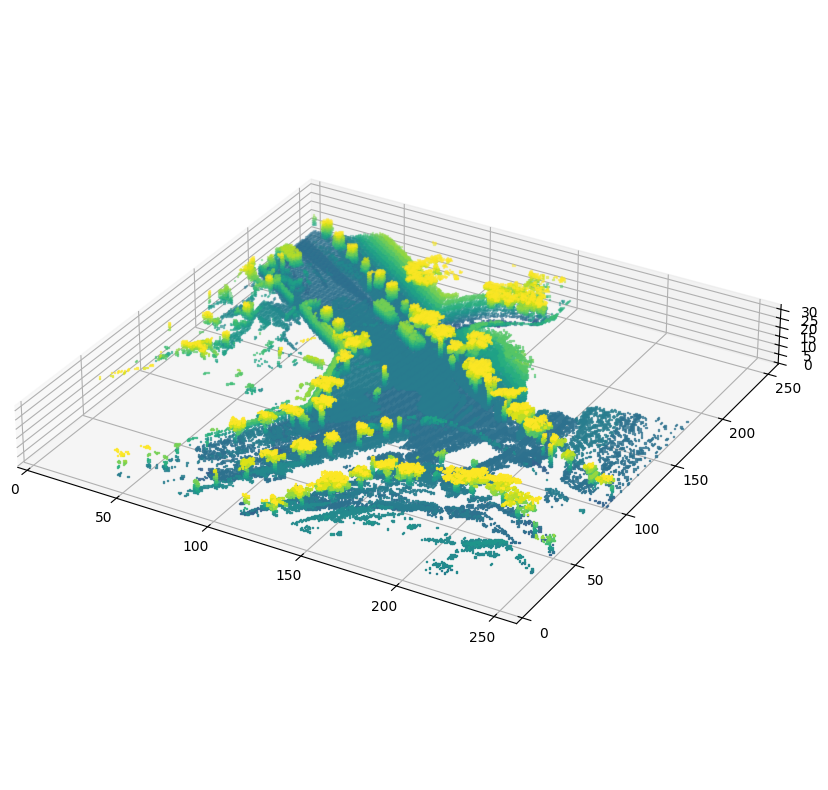

In [5]:
def show_occ(occ):
    with plt.ioff():
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        i,j,k = torch.where(occ[0, 0])
        ax.scatter(i,j,k, marker='s', s=1, c=k)
        ax.set_xlim(0, occ.shape[-3])
        ax.set_ylim(0, occ.shape[-2])
        ax.set_zlim(0, occ.shape[-1])
        ax.set_box_aspect((1,1,occ.shape[-1]/occ.shape[-2]))
        return fig

occ0_fig = show_occ(occ0)
occ0_fig

In [59]:

def build_kernel(size: int, sigma: float) -> torch.Tensor:
    grid = torch.arange(size, dtype=torch.float32)
    grid -= (size - 1) / 2
    grid = grid / sigma
    grid = grid ** 2
    grid = -0.5 * grid
    grid = torch.exp(grid)
    grid = grid / grid.sum()
    return grid

def occ_approx_roi(occ):
    #occ = occ.argmax(dim=1, keepdim=True)
    occ = occ > 0
    gaussian_blur_kernel3d = build_kernel(7, 1)
    gaussian_blur_kernel3d = gaussian_blur_kernel3d[None, :] * gaussian_blur_kernel3d[:, None] * gaussian_blur_kernel3d[:, None, None]
    gaussian_blur_kernel3d = gaussian_blur_kernel3d / gaussian_blur_kernel3d.sum()
    gaussian_blur_kernel3d = gaussian_blur_kernel3d[None, None, ...]
    mask = F.conv3d(occ.float(), gaussian_blur_kernel3d.to(device=occ.device), padding=3)
    mask = mask > 0
    mask = mask.any(dim=-1, keepdim=True).expand_as(mask)
    return mask

In [60]:
occ0.shape

torch.Size([1, 1, 256, 256, 32])

In [61]:
occ1 = occ_approx_roi(occ0.cuda()).cpu()
#occ1 = occ1.any(dim=-1, keepdim=True).expand_as(occ1)

In [62]:
occ1.sum()

tensor(1446272)

In [63]:
print(occ1.shape)

torch.Size([1, 1, 256, 256, 32])


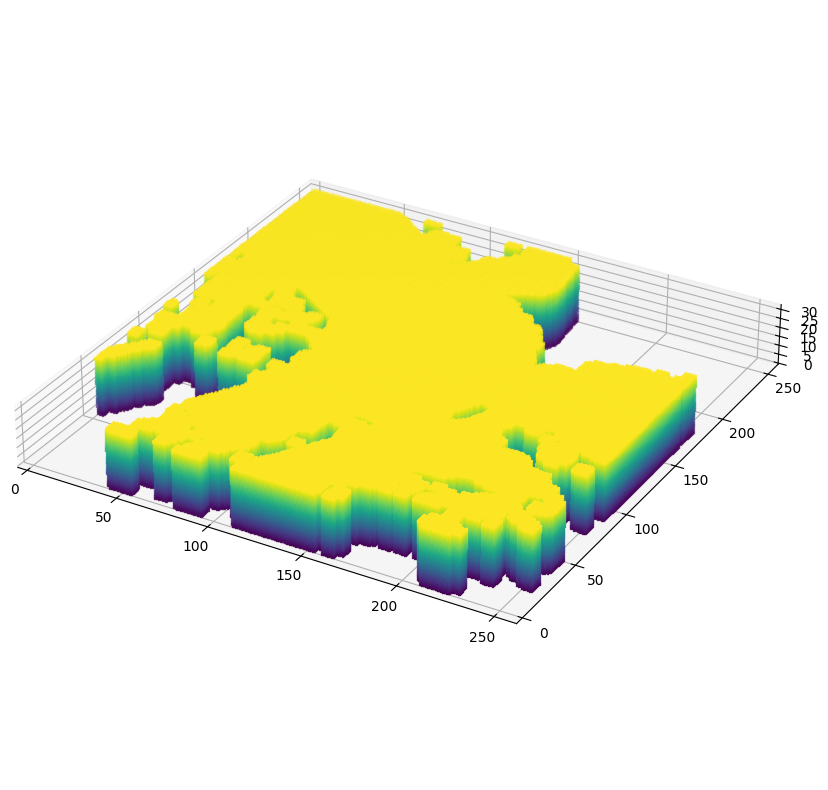

In [64]:
occ1_fig = show_occ(occ1)
occ1_fig

In [ ]:
from occupancy import ops
def occ_approx_roi(occ: Tensor):
    
    occ = occ.argmax(0)
    occ = occ != 0
    F.gaussian_blur(occ.float(), kernel_size=3, sigma=2)


In [22]:
dinov2_vitl14.forward_features(img)

In [21]:
dinov2_vitl14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [20]:
preds.shape

torch.Size([1, 1024])

In [3]:
import numpy as np
from PIL import Image
import cv2
import torch
import os
os.chdir('/home/zc2309/workspace/occupancy/Depth_Anything')
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
model = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitl14")

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = np.array(image) / 255.0
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0).cuda()
model.cuda()

depth = model(image)


In [8]:
depth[0].max()

tensor(191.9806, device='cuda:0', grad_fn=<MaxBackward1>)

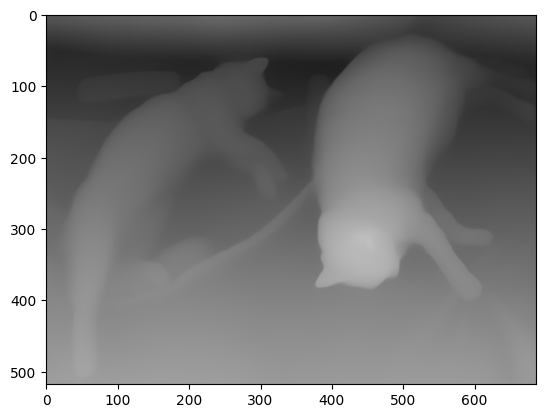

In [6]:
import torchvision.transforms.v2.functional as TF
import matplotlib.pyplot as plt
plt.imshow(TF.to_pil_image(depth[0].cpu(), mode='F'))

In [ ]:
import torch
torch.export.export()

In [ ]:
import torch
from occupancy.ops import view_as_cartesian, view_as_polar


x = torch.rand(1, 1, 64, 64, 64)
z = view_as_polar(x, (512, 512, 512), mode='bilinear')
x_ = view_as_cartesian(z, (64, 64, 64), mode='bilinear')

In [ ]:
(x - x_).abs().max()